In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

import pandas as pd
import gc
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier,AdaBoostClassifier,VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import random
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import auc, roc_curve 

In [0]:
import warnings 
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

## 1. Introduction

The failure of patients to attend medical appointments (no-shows) costs healthcare systems a great deal of time and money.  The aim of this project was to construct a machine learning model capable of predicting no-shows ahead of time.  The data that was used provides the details of over 110,000 medical appointments scheduled over the course of April, May and June 2016 at various clinics in the Brazilian city of Vitoria.  

Source: https://www.kaggle.com/joniarroba/noshowappointments

## 2. Loading Data and Inspecting

In [0]:
data = pd.read_csv('/content/drive/My Drive/KaggleV2-May-2016.csv')
#data = pd.read_csv('KaggleV2-May-2016.csv')


In [48]:
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [49]:
data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


## 3. Feature Engineering

The original features of interest in this dataset are;

- Patient Gender

- ScheduledDay - date and time of when the appointment booking was done.

- AppointmentDay - date (without time) that the appointment was scheduled for.

- Patient Age

- Neighbourhood - neighbourhood that the clinic is located in.  All neighbourhoods are in the city of Vitoria, Brazil.

- Scholarship - binary feature indicating whether the patient is on a particular Brazilian social assistance program.  The data source provides this wikipedia article as further explanation - https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia.

- Hipertension, Diabetes and Alcoholism - binary features indicating whether the patient suffers from any of these conditions.

- Handcap - numerical feature (from 1 to 4) indicating degree of physical disability.

- SMS_received - binary feature indicating whether a text reminder was received by the patient.

- No-show - binary feature indicating whether or not the patient missed their appointment.

Several additional features are derived below.

In [0]:
# map labels to 1 and 0

data['Labels'] = data['No-show'].map({'Yes': 1, 'No': 0})


Creating new features; "high_temp" and "rainfall" - giving highest temperature (in C) and total rainfall (in mm) for each appointment day.  The supplementary weather data was obtained from https://www.worldweatheronline.com/vitoria-weather-history/espirito-santo/br.aspx

In [0]:
# map appointment days to historical weather data

# daily high temp (in C)
temps_dict = {'2016-06-06T00:00:00Z' : 31,
              '2016-05-16T00:00:00Z' : 28,
              '2016-05-09T00:00:00Z' : 28,
              '2016-05-30T00:00:00Z' : 28,
              '2016-06-08T00:00:00Z' : 24,
              '2016-05-11T00:00:00Z' : 29,
              '2016-06-01T00:00:00Z' : 29,
              '2016-06-07T00:00:00Z' : 27,
              '2016-05-12T00:00:00Z' : 27,
              '2016-05-02T00:00:00Z' : 24,
              '2016-05-18T00:00:00Z' : 25,
              '2016-05-17T00:00:00Z' : 28,
              '2016-06-02T00:00:00Z' : 30,
              '2016-05-10T00:00:00Z' : 28,
              '2016-05-31T00:00:00Z' : 25,
              '2016-05-05T00:00:00Z' : 26,
              '2016-05-19T00:00:00Z' : 24,
              '2016-05-03T00:00:00Z' : 25,
              '2016-05-04T00:00:00Z' : 27,
              '2016-06-03T00:00:00Z' : 27,
              '2016-05-24T00:00:00Z' : 24,
              '2016-05-13T00:00:00Z' : 25,
              '2016-05-25T00:00:00Z' : 23,
              '2016-05-06T00:00:00Z' : 26,
              '2016-05-20T00:00:00Z' : 24,
              '2016-04-29T00:00:00Z' : 24,
              '2016-05-14T00:00:00Z' : 23}

# total rainfall on that day (in mm)
rain_dict = {'2016-06-06T00:00:00Z' : 0,
              '2016-05-16T00:00:00Z' : 0.03,
              '2016-05-09T00:00:00Z' : 0.12,
              '2016-05-30T00:00:00Z' : 0.37,
              '2016-06-08T00:00:00Z' : 2.67,
              '2016-05-11T00:00:00Z' : 0,
              '2016-06-01T00:00:00Z' : 0,
              '2016-06-07T00:00:00Z' : 1.26,
              '2016-05-12T00:00:00Z' : 5.3,
              '2016-05-02T00:00:00Z' : 0,
              '2016-05-18T00:00:00Z' : 1.67,
              '2016-05-17T00:00:00Z' : 0.74,
              '2016-06-02T00:00:00Z' : 0.38,
              '2016-05-10T00:00:00Z' : 0,
              '2016-05-31T00:00:00Z' : 1.53,
              '2016-05-05T00:00:00Z' : 0.02,
              '2016-05-19T00:00:00Z' : 0.56,
              '2016-05-03T00:00:00Z' : 0.47,
              '2016-05-04T00:00:00Z' : 0.13,
              '2016-06-03T00:00:00Z' : 2.2,
              '2016-05-24T00:00:00Z' : 0.1,
              '2016-05-13T00:00:00Z' : 0.28,
              '2016-05-25T00:00:00Z' : 1.08,
              '2016-05-06T00:00:00Z' : 0.34,
              '2016-05-20T00:00:00Z' : 0.84,
              '2016-04-29T00:00:00Z' : 3.58,
              '2016-05-14T00:00:00Z' : 1.16}          

data['high_temp'] = data['AppointmentDay'].map(temps_dict)  
data['rainfall'] = data['AppointmentDay'].map(rain_dict)


Creating new feature - "impeachment_vote" - the only significant news story in Brazil during the range of dates in question was their Senate voting to impeach the president on May 12, 2016.  Can distractions like this affect appointment compliance?

In [0]:
# 1 for impeachment date, 0 for all others
data['impeachment_vote'] = 0
data['impeachment_vote'] = data['AppointmentDay'].map(lambda x: 1 if x == '2016-05-12T00:00:00Z' else 0)

Creating new time-related features;

days_to_appt - days between booking date and appointment.

day_of_appt - day of the week of the appointment.

day_of_scheduling - day of the week of the booking date.

month_of_appt - month of the year of the appointment.

month_of_scheduling - month of the year of the booking date.

hour_of_scheduling - hour of the day during which the appointment booking took place. (Actual appointment time was not provided.) 


In [0]:
# convert date objects to datetime format (without time part)
data['ScheduledDayDT'] = pd.to_datetime(data['ScheduledDay']).dt.date
data['ScheduledDayDT'] = pd.to_datetime((data['ScheduledDayDT']),utc=True)
data['AppointmentDayDT'] = pd.to_datetime(data['AppointmentDay'])

In [0]:
# create new feature - "days_to_appt" - no. of days between scheduled date and appt date
data['time_between_appts'] = data['AppointmentDayDT']-data['ScheduledDayDT']
data['days_to_appt'] = data['time_between_appts']/np.timedelta64(1,'D')

In [0]:
# create new features - day of the week and month of the year of the scheduling and appointment dates, hour of scheduling
data['day_of_appt'] = data['AppointmentDayDT'].dt.dayofweek
data['day_of_scheduling'] = data['ScheduledDayDT'].dt.dayofweek
data['month_of_appt'] = data['AppointmentDayDT'].dt.month
data['month_of_scheduling'] = data['ScheduledDayDT'].dt.month
data['hour_of_scheduling'] = pd.to_datetime(data['ScheduledDay']).dt.hour

Creating new features regarding past patient history;

prior_no_shows - number of no-shows the patient had prior to the current appointment.

prior_visits - number of total scheduled appointments the patient had prior to the current appointment.

visit_freq - frequency of visits (appts/day for each pt, = 0 if they only had one appt 
in the dataset)

In [57]:
# loop below takes several mins to run, you can just read in the data by running the cell below this one

'''
data['prior_no_shows'] = 0
data['prior_visits'] = 0
data['visit_freq'] = 0

for i in data.index: 
  
  # how many no-shows and overall visits happened for this PatientId, prior to current date?
  data.loc[i,'prior_no_shows']=len(data[(data['PatientId']==data.loc[i,'PatientId']) & (data['AppointmentDayDT']<data.loc[i,'AppointmentDayDT']) & (data['Labels']==1)])
  data.loc[i,'prior_visits']=len(data[(data['PatientId']==data.loc[i,'PatientId']) & (data['AppointmentDayDT']<data.loc[i,'AppointmentDayDT'])])

  # visit frequency = total visits/(latest-earliest visit)
  max_date = data[data['PatientId']==data.loc[i,'PatientId']]['AppointmentDayDT'].max()
  min_date = data[data['PatientId']==data.loc[i,'PatientId']]['AppointmentDayDT'].min()
  
  if (max_date>min_date): # if there's only 1 appt it stays as zero
      data.loc[i,'visit_freq'] = float(len(data[data['PatientId']==data.loc[i,'PatientId']]))/((max_date-min_date)/np.timedelta64(1,'D'))   

# write the new columns to disk or google drive
data[['prior_no_shows','prior_visits','visit_freq']].to_csv('prior_no_shows.csv')    
!cp prior_no_shows.csv drive/My\ Drive/  # only if using colab

'''

"\ndata['prior_no_shows'] = 0\ndata['prior_visits'] = 0\ndata['visit_freq'] = 0\n\nfor i in data.index: \n  \n  # how many no-shows and overall visits happened for this PatientId, prior to current date?\n  data.loc[i,'prior_no_shows']=len(data[(data['PatientId']==data.loc[i,'PatientId']) & (data['AppointmentDayDT']<data.loc[i,'AppointmentDayDT']) & (data['Labels']==1)])\n  data.loc[i,'prior_visits']=len(data[(data['PatientId']==data.loc[i,'PatientId']) & (data['AppointmentDayDT']<data.loc[i,'AppointmentDayDT'])])\n\n  # visit frequency = total visits/(latest-earliest visit)\n  max_date = data[data['PatientId']==data.loc[i,'PatientId']]['AppointmentDayDT'].max()\n  min_date = data[data['PatientId']==data.loc[i,'PatientId']]['AppointmentDayDT'].min()\n  \n  if (max_date>min_date): # if there's only 1 appt it stays as zero\n      data.loc[i,'visit_freq'] = float(len(data[data['PatientId']==data.loc[i,'PatientId']]))/((max_date-min_date)/np.timedelta64(1,'D'))   \n\n# write the new columns

In [0]:
# use this to just read in the data instead of running the cells above
prior_no_shows = pd.read_csv('/content/drive/My Drive/prior_no_shows.csv') # change to local dir if not using colab
data['prior_no_shows'] = prior_no_shows['prior_no_shows']
data['prior_visits'] = prior_no_shows['prior_visits']
data['visit_freq'] = prior_no_shows['visit_freq']


## 4. Exploratory Analysis

No-shows make up approximately 20% of the data, while 80% of appointments were attended.

In [304]:
# check balance of labels

no = len(data[data['No-show']=='No'])
yes = len(data[data['No-show']=='Yes'])
total = len(data)

print('Number of Rows with No-Show = Yes: ', yes,'(',np.round(yes/total*100,2),'%), Number of rows with No-show = No: ', no,'(',np.round(no/total*100,2),'%)')

Number of Rows with No-Show = Yes:  22319 ( 20.19 %), Number of rows with No-show = No:  88208 ( 79.81 %)


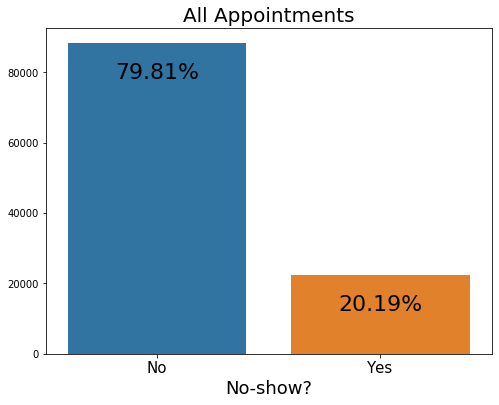

In [317]:
plt.figure(figsize=(8,6))
plt.title('All Appointments',fontsize=20)
fig = sns.countplot(x='No-show',data=data)
plt.xlabel('No-show?',fontsize=18)
plt.ylabel('',fontsize=18)
plt.xticks(fontsize=15)

for a in fig.patches:
    height = a.get_height()
    fig.text(a.get_x()+a.get_width()/2.,
            height -10000,
             '{:1.2f}'.format(height/110527*100)+'%',
             ha="center",fontsize=22)

Below we look at correlations between the various features and the labels.

In [305]:
#Correlation analysis
corr=data.corr()
corr['Labels'].sort_values(ascending=False)

Labels                 1.000000
days_to_appt           0.186231
SMS_received           0.126431
prior_no_shows         0.078592
hour_of_scheduling     0.060697
Scholarship            0.029135
day_of_scheduling      0.006020
day_of_appt            0.001165
Alcoholism            -0.000196
high_temp             -0.001033
PatientId             -0.001461
impeachment_vote      -0.005801
Handcap               -0.006076
rainfall              -0.014748
Diabetes              -0.015180
visit_freq            -0.016729
prior_visits          -0.020710
month_of_appt         -0.020886
Hipertension          -0.035701
Age                   -0.060319
month_of_scheduling   -0.160862
AppointmentID         -0.162602
Name: Labels, dtype: float64

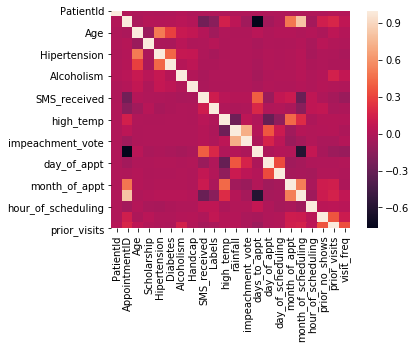

In [306]:
#Heatmap
ax = sns.heatmap(corr,  square=True)

In [307]:
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Labels,high_temp,rainfall,impeachment_vote,ScheduledDayDT,AppointmentDayDT,time_between_appts,days_to_appt,day_of_appt,day_of_scheduling,month_of_appt,month_of_scheduling,hour_of_scheduling,prior_no_shows,prior_visits,visit_freq,age_binned_total,age_binned,days_binned
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0,24,3.58,0,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,0 days,0.0,4,4,4,4,18,0,0,0.0,"(60, 65]","(60, 65]","(-1.0, 0.0345]"
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0,24,3.58,0,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,0 days,0.0,4,4,4,4,16,0,0,0.0,"(55, 60]","(55, 60]","(-1.0, 0.0345]"
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,0,24,3.58,0,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,0 days,0.0,4,4,4,4,16,0,0,0.0,"(60, 65]","(60, 65]","(-1.0, 0.0345]"
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0,24,3.58,0,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,0 days,0.0,4,4,4,4,17,0,0,0.1,"(5, 10]","(5, 10]","(-1.0, 0.0345]"
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0,24,3.58,0,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,0 days,0.0,4,4,4,4,16,0,0,0.0,"(55, 60]","(55, 60]","(-1.0, 0.0345]"


In [0]:
# keep only desired features and labels
data_clean = data[['Labels','Gender','Age','SMS_received','day_of_appt','day_of_scheduling','month_of_appt','month_of_scheduling','hour_of_scheduling','days_to_appt','prior_no_shows','prior_visits',
                   'high_temp','rainfall','visit_freq','Scholarship']]
                   
#data_clean = data_clean[0:10000]

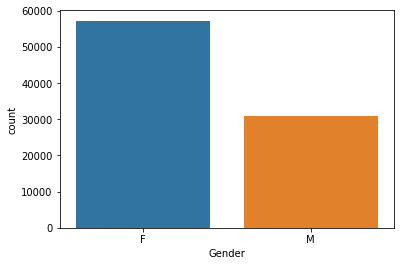

In [309]:
#Who visits the doctor frequently ?
visiting = data[data['No-show'] == 'No']
sns.countplot(x = 'Gender', data = visiting)

In [310]:
# What is the patient age distribtuion for no shows versus those who
#shows up for the apppointment ?

data.groupby('No-show')['Age'].mean()

No-show
No     37.790064
Yes    34.317667
Name: Age, dtype: float64

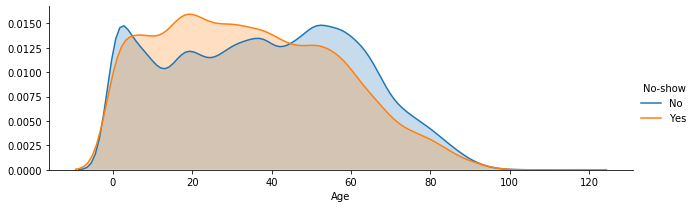

In [311]:

figure = sns.FacetGrid(data, hue='No-show', aspect=3)
figure.map(sns.kdeplot, 'Age', shade= True)
figure.add_legend()

Text(0.5, 1.0, 'No-show rate vs. Age')

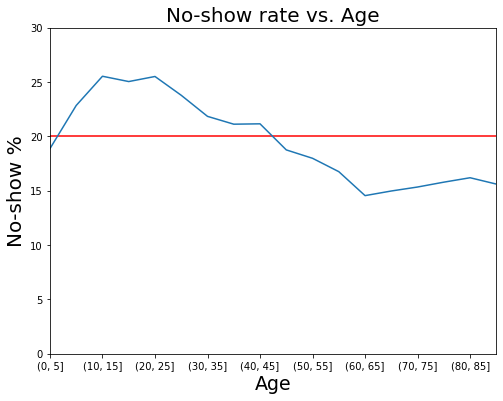

In [329]:
age_bins = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]
data['age_binned'] = pd.cut(data['Age'], age_bins)
age_totals = data.groupby(pd.cut(data['Age'], bins=age_bins)).size()
age_yes = data[data['No-show']=='Yes'].groupby(pd.cut(data[data['No-show']=='Yes']['Age'], bins=age_bins)).size()
age_no = data[data['No-show']=='No'].groupby(pd.cut(data[data['No-show']=='No']['Age'], bins=age_bins)).size()
age_rate = age_yes/age_totals*100

plt.figure(figsize=(8,6))
plt.hlines(20,0,100,'r')
plt.ylim(0,30)
age_rate.plot()
plt.ylabel('No-show %',fontsize=20,)
plt.xlabel('Age',fontsize=19)
plt.xticks(fontsize=10)
plt.title('No-show rate vs. Age',fontsize=20)

(-2, 30)

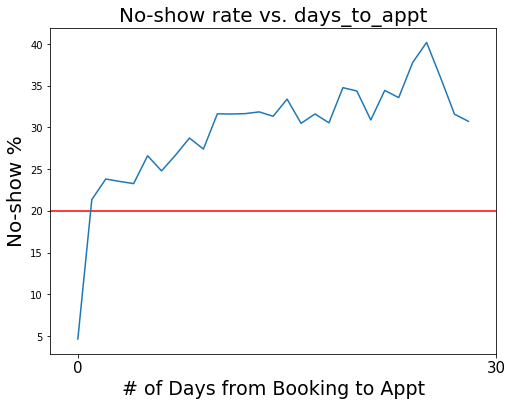

In [330]:
## examine how no-show rate varies with days between booking and appt

days_bins = np.linspace(-1,29,30)
data['days_binned'] = pd.cut(data['days_to_appt'], days_bins)
days_totals = data.groupby(pd.cut(data['days_to_appt'], bins=days_bins)).size()
days_yes = data[data['No-show']=='Yes'].groupby(pd.cut(data[data['No-show']=='Yes']['days_to_appt'], bins=days_bins)).size()
days_no = data[data['No-show']=='No'].groupby(pd.cut(data[data['No-show']=='No']['days_to_appt'], bins=days_bins)).size()
days_rate = days_yes/days_totals*100

plt.figure(figsize=(8,6))
plt.hlines(20,-100,100,'r')

days_rate.plot()
plt.ylabel('No-show %',fontsize=20,)
plt.xlabel('# of Days from Booking to Appt',fontsize=19)
plt.xticks([0,30],[0,30],fontsize=15)
plt.title('No-show rate vs. days_to_appt',fontsize=20)
plt.xlim(-2,30)


In [314]:
#Number of males vs females in this dataset

data['Gender'].value_counts(normalize = False)

F    71840
M    38687
Name: Gender, dtype: int64

In [186]:
data[data['Gender']=='M']['No-show'].value_counts()

No     30962
Yes     7725
Name: No-show, dtype: int64

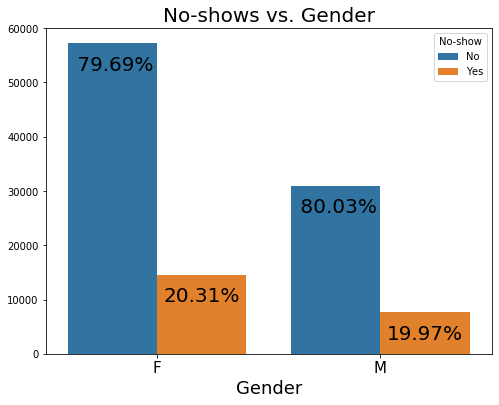

In [319]:
## get a breakdown of gender and no-show rate

plt.figure(figsize=(8,6))
plt.title('No-shows vs. Gender',fontsize=20)
ax = sns.countplot(x = 'Gender', hue = 'No-show', data=data)
plt.ylabel('')
plt.xlabel('Gender',fontsize=18)
plt.xticks(fontsize=15)

bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]

for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r

    ax.text(left.get_x() + left.get_width()/2., height_l -5000, ' {:1.2f}'.format(100*height_l/total)+'%', ha="center",fontsize=20)
    ax.text(right.get_x() + right.get_width()/2., height_r -5000,  '{:1.2f}'.format(100*height_r/total)+'%', ha="center",fontsize=20)


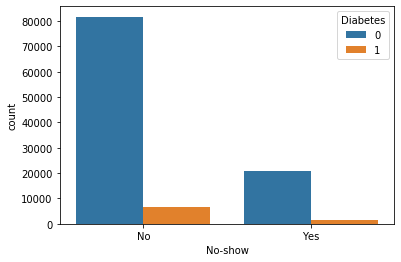

In [0]:
#Now we will compare the relation of no-show with various features

#First we will check the relationship between no-show vs Diabetes

sns.countplot(x = 'No-show', hue='Diabetes', data=data)

In [0]:
#Next we compare the realtionship of No-show with the following features

#-'Scholarship'
#-'Hipertension'
#-'Alcoholism'
#-'Handcap'

Text(0.5, 1.0, 'No-show vs Alcoholism')

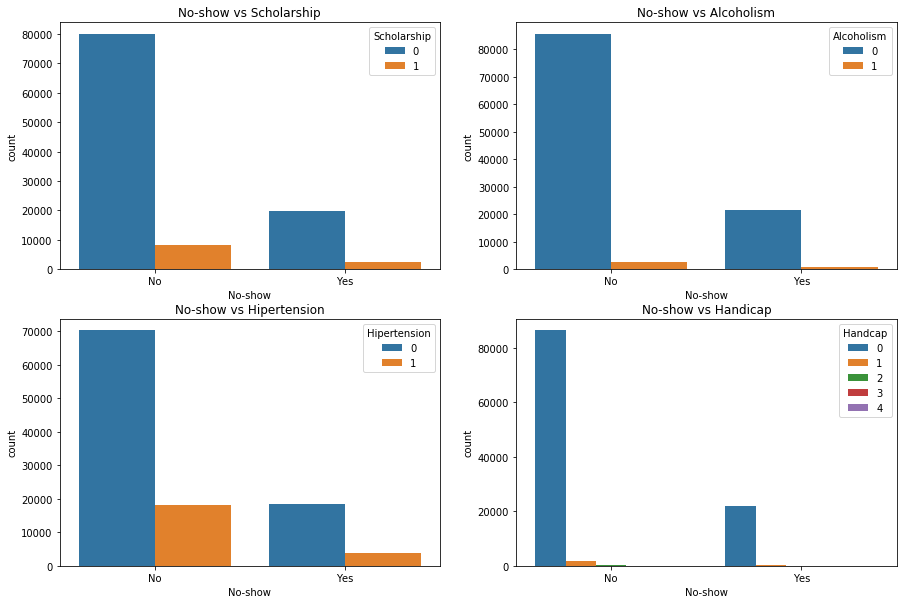

In [0]:
fig, ax =plt.subplots(2,2, figsize=(15,10))
sns.countplot(x='No-show', hue='Scholarship', data=data, ax=ax[0][0]).set_title('No-show vs Scholarship')
sns.countplot(x='No-show', hue='Handcap', data=data, ax=ax[1][1]).set_title('No-show vs Handicap')
sns.countplot(x='No-show', hue='Hipertension', data=data, ax=ax[1][0]).set_title('No-show vs Hipertension')
sns.countplot(x='No-show', hue='Alcoholism', data=data, ax=ax[0][1]).set_title('No-show vs Alcoholism')

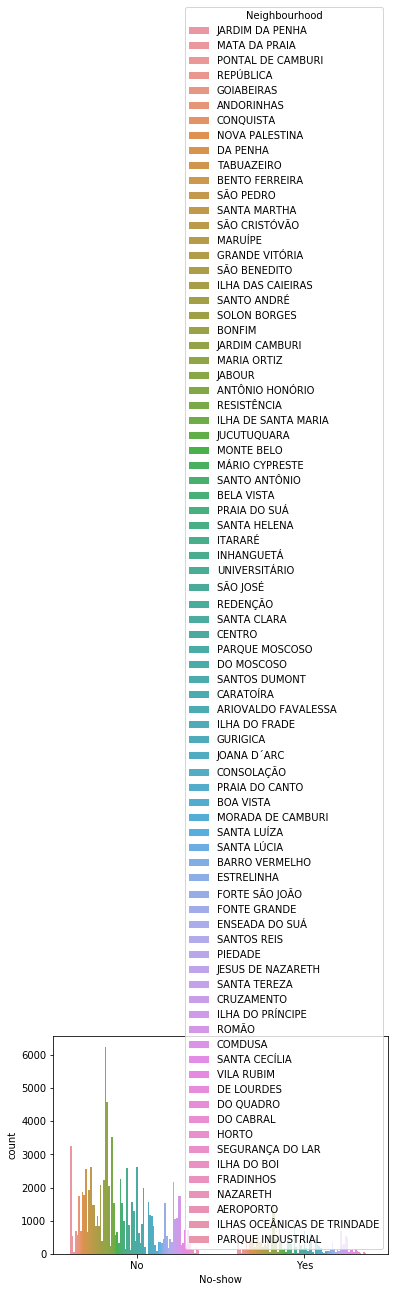

In [0]:
#Lastly we compare the relationship between no-shows vs neighbourhoods

sns.countplot(x='No-show', hue='Neighbourhood', data=data)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]),
 <a list of 81 Text xticklabel objects>)

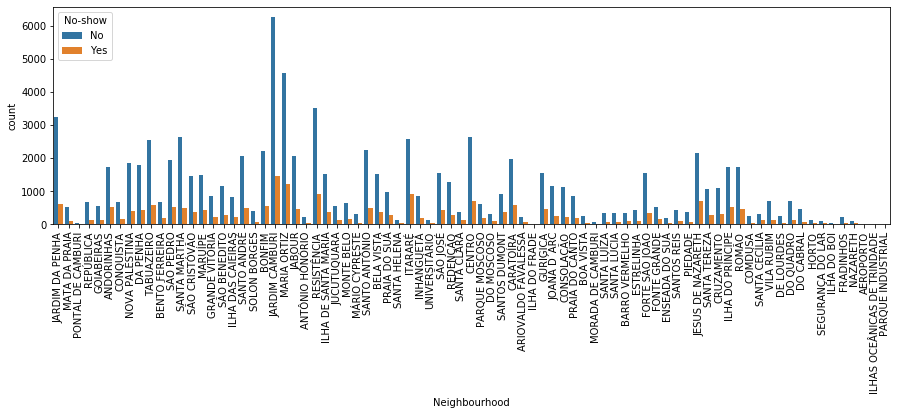

In [0]:
plt.figure(figsize=(15,4))
sns.countplot(x='Neighbourhood', hue='No-show', data=data)
plt.xticks(rotation=90)

In [0]:
#Determining which neighbourhood has the highest number of no shows

neigh_no_show = data[data['No-show'] == 'No']
neigh_no_show.groupby('Neighbourhood')['No-show'].count().sort_values(ascending=False)

Neighbourhood
JARDIM CAMBURI       6252
MARIA ORTIZ          4586
RESISTÊNCIA          3525
JARDIM DA PENHA      3246
SANTA MARTHA         2635
                     ... 
PONTAL DE CAMBURI      57
ILHA DO BOI            32
ILHA DO FRADE           8
AEROPORTO               7
PARQUE INDUSTRIAL       1
Name: No-show, Length: 80, dtype: int64

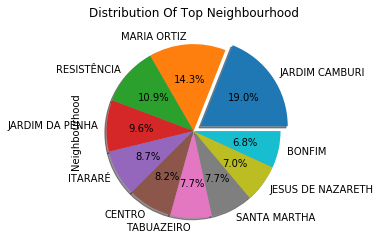

In [0]:
# Plotting the distribution of Neighbourhood with pie-chart.
plt.subplots(figsize=(8,4))
data['Neighbourhood'].value_counts()[:10].plot(kind='pie',autopct='%1.1f%%',shadow=True,explode=[0.1,0,0,0,0,0,0,0,0,0])
plt.title('Distribution Of Top Neighbourhood')
plt.show()

In [0]:
#Determining which neighbourhood has the highest number of shows

neigh_no_show = data[data['No-show'] == 'Yes']
neigh_no_show.groupby('Neighbourhood')['No-show'].count().sort_values(ascending=False)

Neighbourhood
JARDIM CAMBURI                 1465
MARIA ORTIZ                    1219
ITARARÉ                         923
RESISTÊNCIA                     906
CENTRO                          703
                               ... 
PONTAL DE CAMBURI                12
ILHA DO BOI                       3
ILHAS OCEÂNICAS DE TRINDADE       2
ILHA DO FRADE                     2
AEROPORTO                         1
Name: No-show, Length: 80, dtype: int64

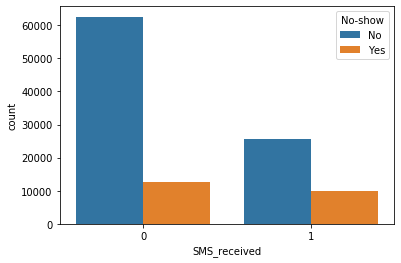

In [0]:
#We like to determine whether a patient would attaned their scheduled 
#appointment if they received an sms.

sns.countplot(x='SMS_received', hue = 'No-show', data = data)

In [0]:
#https://github.com/mwaskom/seaborn/issues/1027

We found it surprising that people with scholarships were less likely to show up to their appointments. This may be because these patients don't
have to pay for their appointments, so they are not as invested as people who have to pay to see the doctor.

## 5. Preparing for Modelling

The cleaned data is divided into train/test sets (70/30) ratio below. OneHotEncoder() is used to encode categorical features and StandardScaler() is used to transform numerical features.  

In [0]:
data_clean.columns

Index(['Labels', 'Gender', 'Age', 'SMS_received', 'day_of_appt',
       'day_of_scheduling', 'month_of_appt', 'month_of_scheduling',
       'hour_of_scheduling', 'days_to_appt', 'prior_no_shows', 'prior_visits',
       'high_temp', 'rainfall', 'visit_freq', 'Scholarship'],
      dtype='object')

In [0]:
# split into test/train
train_set,test_set = train_test_split(data_clean,test_size=0.3,stratify=data_clean["Labels"])
print(len(train_set), "train +", len(test_set), "test")

# divide into features/labels
train_features = train_set.drop('Labels',axis=1)
train_labels = train_set[['Labels']]
test_features = test_set.drop('Labels',axis=1)
test_labels = test_set[['Labels']]

77368 train + 33159 test


In [0]:
# transform numerical and categorical features using StandardScaler() and OneHotEncoder()
num_attribs = ['Age','days_to_appt','prior_no_shows','high_temp','rainfall','prior_visits','visit_freq']
cat_attribs_one_hot = ['Gender','day_of_appt','day_of_scheduling','month_of_appt','month_of_scheduling','hour_of_scheduling']

pipeline_features = ColumnTransformer(
    [("num",StandardScaler(),num_attribs),("cat",OneHotEncoder(categories='auto',handle_unknown='ignore'),cat_attribs_one_hot)],remainder='passthrough')

train_features_prepared = pipeline_features.fit_transform(train_features)
train_labels_prepared = train_labels.values

test_features_prepared = pipeline_features.transform(test_features)
test_labels_prepared = test_labels.values

In [0]:
train_features_prepared.shape

(77368, 50)

In [0]:
test_features_prepared.shape

(33159, 50)

## 5.Model Selection

Below we will evaluate popular classiifer models on our dataset

In [0]:
# This Function Runs Several Classifiers on Training Data with 3 cv-folds, Prints Out "metric" score of each Model
metrics=['accuracy', 'precision', 'recall','roc_auc']
def testClassifiers(train_features,train_labels,metrics=[]):
    LOG=LogisticRegression()
    DTC=DecisionTreeClassifier()
    RFC=RandomForestClassifier(n_estimators=100)
    KNN=KNeighborsClassifier()
    SGD=SGDClassifier()
    SVC_CLF = SVC(kernel="rbf") 
    XGB=XGBClassifier()

    classifier_list = [LOG,DTC,RFC,KNN,XGB]

    score_list=[]
    for c in classifier_list:
        print(type(c).__name__)
        for m in metrics:
            #can use cross_validate with multiple scores insteadto make this run faster
            cv_results = cross_val_score(c,train_features_prepared,train_labels_prepared,cv=3,scoring=m)
            score_list.append([type(c).__name__,m,np.mean(cv_results)])
            print('-------------------')
            print('Scoring Metric: ', m)
            print('Scores: ',cv_results)
            print('Mean Score: ',np.round(np.mean(cv_results),3))
            print('')

    scores=pd.DataFrame(score_list,columns=['classifier','metric','score'])
    return scores


In [0]:
scores = testClassifiers(train_features_prepared,train_labels_prepared, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

LogisticRegression
-------------------
Scoring Metric:  accuracy
Scores:  [0.79697557 0.79635518 0.79626183]
Mean Score:  0.797

-------------------
Scoring Metric:  precision
Scores:  [0.45882353 0.43678161 0.43227666]
Mean Score:  0.443

-------------------
Scoring Metric:  recall
Scores:  [0.02995392 0.02918587 0.02880737]
Mean Score:  0.029

-------------------
Scoring Metric:  f1
Scores:  [0.05623648 0.05471562 0.05401512]
Mean Score:  0.055

-------------------
Scoring Metric:  roc_auc
Scores:  [0.69055149 0.67885679 0.6774215 ]
Mean Score:  0.682

DecisionTreeClassifier
-------------------
Scoring Metric:  accuracy
Scores:  [0.72089957 0.71868941 0.7179696 ]
Mean Score:  0.719

-------------------
Scoring Metric:  precision
Scores:  [0.32098765 0.32181851 0.30973612]
Mean Score:  0.318

-------------------
Scoring Metric:  recall
Scores:  [0.34927035 0.34581413 0.32590743]
Mean Score:  0.34

-------------------
Scoring Metric:  f1
Scores:  [0.33289987 0.32998062 0.32193572]
Mean

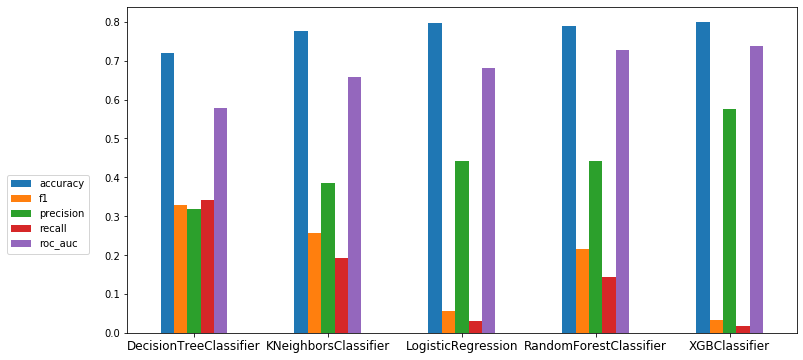

In [0]:
# graph all scores for comparison
scores = scores.pivot(index='classifier',columns='metric',values='score')
scores.plot(kind='bar',figsize=(12,6))
plt.xlabel('')
plt.xticks(rotation='horizontal',fontsize=12)
plt.legend(title='',bbox_to_anchor=(-0.05,0.5))

None of the models above had very high scores. Given this fact, what makese sense for our business scenario would be to focus on maximizing precision (at the expense of recall). Acheving high scores for both is difficult given the weakness of our dataset. However, we may be able to maximize one over the other.


Based on the above scores, some of the models that stood out are KNN, and RFC. We can try to tune hyperparmataers for these

In [0]:
#grid search
from sklearn.model_selection import GridSearchCV

param_grid_RFC = { 'n_estimators' : [10,100,200]}

param_grid_KNN = { 'n_neighbors' : [2,10,40,50,60]}


#Random Forests

cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_RFC, cv= 3,
                      scoring='precision')
cv_results=cv.fit(train_features_prepared,train_labels_prepared)
print(cv_results.best_score_)
print(cv_results.best_params_)


#KNN
cv = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_KNN, cv= 3,
                      scoring='precision')
cv_results=cv.fit(train_features_prepared,train_labels_prepared)

print(cv_results.best_score_)
print(cv_results.best_params_)




0.4514318249948403
{'n_estimators': 200}
0.5850039860012546
{'n_neighbors': 100}


Below builts a voting classifier ensembles using our best models

In [0]:

#all models
    
LOG=LogisticRegression()
RFC=RandomForestClassifier(n_estimators=100) #theis estimator number gave us best preicison avg
KNN=KNeighborsClassifier(n_neighbors=10) #this neighbors gives highets precision
XGB=XGBClassifier()

    
voting_clf = VotingClassifier(
    estimators=[('LOG', LOG),('KNN',KNN),('XGB',XGB),('RFC', RFC)],
    voting='hard')

In [0]:

#model to use
model=voting_clf

In [0]:
#cross validation
metrics=['accuracy', 'precision', 'recall']
for m in metrics:
    #can use cross_validate with multiple scores insteadto make this run faster
    cv_results = cross_val_score(model,train_features_prepared,train_labels_prepared,cv=4,scoring=m)
    print('-------------------')
    print('Scoring Metric: ', m)
    print('Scores: ',cv_results)

-------------------
Scoring Metric:  accuracy
Scores:  [0.79915215 0.79960707 0.79929687 0.80016545]
-------------------
Scoring Metric:  precision
Scores:  [0.63157895 0.69736842 0.71014493 0.73493976]
-------------------
Scoring Metric:  recall
Scores:  [0.01356887 0.0140809  0.0125448  0.01459667]


Our voting classifier was able to come up with precision score (0.6) much higher than any of the individual models.

Best individual model precision was 0.4

Voting calssifier precision is around 0.6

### Predict

In [0]:
#Prediction

#fit model on entire training set
model.fit(train_features_prepared,train_labels_prepared)

y_test_pred = model.predict(test_features_prepared)


In [0]:

#Scores
print('Accuracy =' ,  np.round(accuracy_score(test_labels_prepared, y_test_pred),2))
print('precision = ' , precision_score(test_labels_prepared, y_test_pred))
print('recall  = ', recall_score(test_labels_prepared, y_test_pred))
print('f1  = ', f1_score(test_labels_prepared, y_test_pred))
print('auc = ', roc_auc_score(test_labels_prepared, y_test_pred))
confusion_matrix(test_labels_prepared,y_test_pred)

Accuracy = 0.8
precision =  0.7441860465116279
recall  =  0.014336917562724014
f1  =  0.02813186813186813
auc =  0.506544946707901


array([[26430,    33],
       [ 6600,    96]])

In [0]:
accuracy = np.round(accuracy_score(test_labels_prepared, y_test_pred),2)
precision = precision_score(test_labels_prepared, y_test_pred)
recall = recall_score(test_labels_prepared, y_test_pred)
f_score = f1_score(test_labels_prepared, y_test_pred)

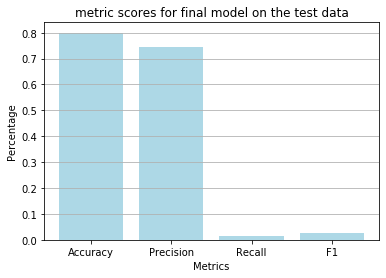

In [0]:
%matplotlib inline

x = ['Accuracy', 'Precision','Recall', 'F1']
metrics = [accuracy, precision, recall, f_score]
plt.gca().yaxis.grid(True)
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, metrics, color='lightblue')
plt.xlabel("Metrics")
plt.ylabel("Percentage")
plt.xticks(x_pos, x)
plt.title('metric scores for final model on the test data')
plt.show()

#Conclusions

This model can predict whether or not patients are going to show up to their appointments with a 80% accuracy & 75% precision by using the above features.

Although this model still can be improved, this is a good score given the following:

1)Weak dataset with extrmeely low feature correlations vs label (correlation less than 0.1 for most features)

2)very poor individual model scores (less than 0.4 precision for most)

-[link text](https://)The final model has a 0.75 precision but a very low recall. This means the model will not recall the majority of no shows. But the No shows we do predict wil be done with 75% precision.

-The implication for the hospital is that they can afford to schedule extra patients to fill in no shows with fairly high trust of our no show predidiction (75%)



-To encourage people to commit to their appointments, clinics should send them SMS reminders or some other form of reminder. Some people have busy lives and may have forgotten about their appointments, especially if they made the appointments months in advance.

###How to potentially improve model

The model could make better predictions if addtional variables were included such as

-Time of appointment

-What type of doctor is the patient going to see? (Primary care provider, CARDIO, OBGYN, ...)

-What mode of transportation will the patient use?

-How far is the patient from the care facility location?